In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt

from modules import ELBO, direct_estimation, compute_curvature
from utils import load_sim_data, log_likelihood

In [2]:
import os
import matlab.engine
os.chdir('/Users/nguyentiendung/GitHub/perceptual-straightening/simulations/')

### Run manually

Epoch: 0, Loss: 133.3212890625
Epoch: 50, Loss: 44.34375
Epoch: 100, Loss: 38.02880859375
Epoch: 150, Loss: 36.9384765625
Epoch: 200, Loss: 36.6875
Epoch: 250, Loss: 36.62353515625
Epoch: 300, Loss: 36.60400390625
Epoch: 350, Loss: 36.60205078125
Epoch: 400, Loss: 36.59716796875
Epoch: 450, Loss: 36.59814453125
Epoch: 500, Loss: 36.59716796875
Epoch: 550, Loss: 36.59814453125
Epoch: 600, Loss: 36.59912109375
Epoch: 650, Loss: 36.5966796875
Epoch: 700, Loss: 36.59814453125
Epoch: 750, Loss: 36.59716796875
Epoch: 800, Loss: 36.59814453125
Epoch: 850, Loss: 36.59765625
Epoch: 900, Loss: 36.5966796875
Epoch: 950, Loss: 36.59716796875


/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


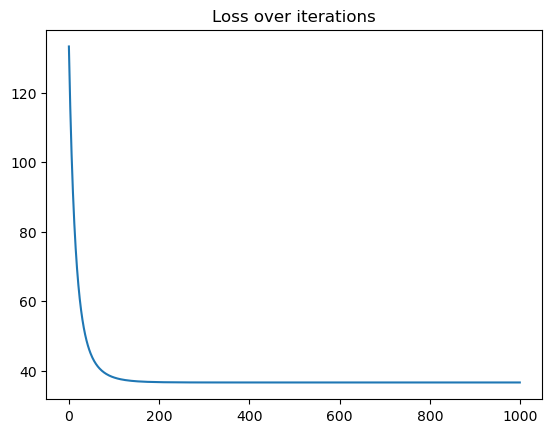

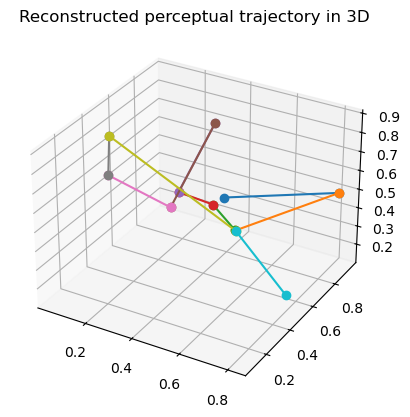

Average global curvature: 110.53649139404297


In [3]:
# call MATLAB function to create trajectory
eng = matlab.engine.start_matlab()
ExpParam, Data, _ = eng.simulation_py(40, 11, 3, 1000, nargout=3)

# stop MATLAB engine
eng.quit()

# set up data
trial_mat = torch.tensor(Data['resp_mat'])
pair_inds = torch.tensor(ExpParam['all_pairs'])

# initialize parameters
N = 11
l = 0.06 # lambda
x = nn.Parameter(torch.rand(1, N, N - 1))

lr = 1e-4
optimizer = torch.optim.SGD([{'params': x}], lr=lr)

# run optimization
iterations = 1000
loss = np.zeros(iterations)
for i in range(iterations):
    log_ll = -torch.sum(log_likelihood(N, trial_mat, pair_inds, x, l))

    # gradient update
    log_ll.backward()
    optimizer.step()
    optimizer.zero_grad()

    # save error
    loss[i] = log_ll.item()

    if not i % 50:
        print(f"Epoch: {i}, Loss: {loss[i]}")

# plot errors
plt.plot(loss)
plt.title('Loss over iterations')
plt.show()

# visualize the perceptual trajectory for >= 3d (plotting first 3 dimensions)
x_np = x.squeeze().detach().numpy().T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(x.shape[1]-1):
    plt.plot([x_np[0, i], x_np[0, i+1]], 
             [x_np[1, i], x_np[1, i+1]],
             [x_np[2, i], x_np[2, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in 3D')
plt.show()

c = compute_curvature(x, N)
print(f'Average global curvature: {torch.mean(c) * (180 / torch.pi)}')

In [4]:
# # load data
# data_path = "/Users/nguyentiendung/GitHub/perceptual-straightening/data/simulations/"
# trial_mat = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'Data.mat')['Data']['resp_mat'][0][0])
# pair_inds = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'ExpParam.mat')['ExpParam']['all_pairs'][0][0]) 

In [5]:
# def compute_curvature(x, N):
#     """
#     Directly compute the curvature form the perceptual trajectories.

#     Inputs:
#     -------
#     x: (N x (N - 1)) torch tensor
#         Array corresponding to the inferred perceptual trajectory, where the second dimension corresponds to the number of dimensions.
#     N: Scalar
#         Number of frames

#     Outputs:
#     --------
#     c: (N) numpy array
#         Inferred average curvature
#     """

#     v_hat = torch.zeros(N-1, N-1) # first index is T, second index is the number of dimensions
#     c = torch.zeros(N-2)
    
#     for t in range(1, N):
#         v = x.squeeze()[t] - x.squeeze()[t-1]
#         v_hat[t-1] = v / torch.linalg.norm(v)
    
#     for t in range(1, N-1):
#         c[t-1] = torch.arccos(v_hat[t-1] @ v_hat[t])

#     return c

### Run direct estimation 100 times for recovery analysis

In [6]:
sim_dir = '/Users/nguyentiendung/GitHub/perceptual-straightening/simulations/'
n_traj = 100
n_frames = 4
n_dim = n_frames - 1
n_iterations = 1000

In [7]:
c_est, c_true, _, _, _ = direct_estimation(sim_dir, n_traj, n_frames, n_dim, n_iterations)

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


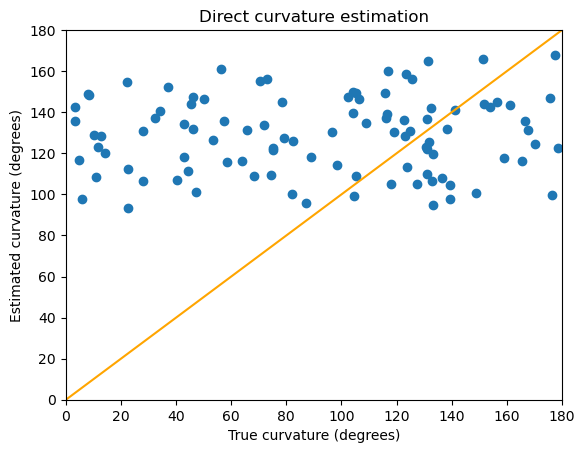

In [11]:
x_diag = np.arange(0, 181, 1)
plt.plot(x_diag, c='orange')

plt.title('Direct curvature estimation')
plt.scatter(c_true.detach().numpy(), c_est.detach().numpy())
plt.xlabel('True curvature (degrees)')
plt.ylabel('Estimated curvature (degrees)')
plt.xlim(0, 180)
plt.ylim(0, 180)
plt.show()